In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [2]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install xmltodict
import xmltodict

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


  Using cached xmltodict-0.12.0-py2.py3-none-any.whl (9.2 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Build the input list of granules - s3fs implementation


In [3]:
%%time
import s3fs
s3 = s3fs.S3FileSystem()
bucket = "s3://maap-ops-workspace"
searchkey_list = [f'nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/master/2021/10/**/*.tif' for DAY in ['03','04','05']]
# Concat list of lists to data frame
topo_path_df = pd.concat([pd.DataFrame(s3.glob(os.path.join(bucket, searchkey)), columns=['maap_path']) for searchkey in searchkey_list])

#Convert data frame to list
INPUT_TILE_NUM_LIST = [i.replace("maap-ops-workspace", "https://maap-ops-workspace.s3.amazonaws.com") for i in topo_path_df.maap_path.to_list()]
len(INPUT_TILE_NUM_LIST)

CPU times: user 228 ms, sys: 46.2 ms, total: 275 ms
Wall time: 1.83 s


0

### Get new tiles for version 3


                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              25
eurasia central        1169
eurasia east           1092
eurasia north           159
eurasia west            612
europe north            290
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70


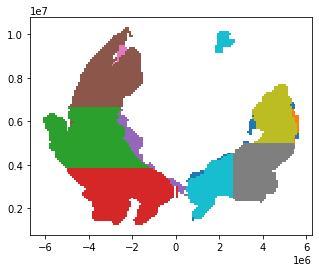

In [4]:
# Get all boreal tiles
boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg' #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
boreal_tile_index = gpd.read_file(boreal_tile_index_path)

bad_tiles = [3540,3634,3728,3823,3916,4004] #Dropping the tiles near antimeridian that reproject poorly.
if True:
    # Remove bad tiles
    boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

boreal_tile_index.plot(column='tile_group')
print(boreal_tile_index.groupby('tile_group')['tile_group'].agg(['count']))

INPUT_TILE_NUM_LIST = boreal_tile_index[boreal_tile_index.tile_group == 'eurasia north'].tile_num.to_list()

In [5]:
 len(INPUT_TILE_NUM_LIST)

159

In [6]:
DO_EXPERIMENT = True

NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()
    
DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

#DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
#BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
#HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                    list(range(3361,3366+1))+\
                    list(range(3454,3459+1))+\
                    list(range(3549,3555+1))+\
                    list(range(3643,3648+1))

INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
len(INPUT_EXPERIMENT_TILE_NUM_LIST)

153

In [8]:
ILAB_AK_TILE = [3000]
KENAI_TILE = [4017]
ARY_MAS_TILE = [37744]
NRWY_TILE = [131]
HOWLAND_TILE = [3421]
BC_TILES = list(range(3846,3868+1)) 
MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES # + NRWY_TILE
len(MISC_TILES)

27

In [24]:
len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST)

180

In [12]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of EXPERIMENT input
List length: 180


# Run a DPS of MS Composite tiles

In [26]:
MAX_CLOUDS = 40
RUN_NAME = f'test_mc{MAX_CLOUDS}_3yrs'
RUN_NAME

'test_mc40_3yrs'

In [27]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': '2019',
                         'end_year': '2021',
                         'start_month_day': '06-01',
                         'end_month_day': '09-15',
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="master",
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 100, 500, 1000, 1500, 2000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 180
DPS run #: 1	| tile num: 37744	| submit status: success	| job id: bab7a334-4976-4307-a532-e5e32a9dfbbe
DPS run #: 100	| tile num: 324	| submit status: success	| job id: e3691dc2-a3ef-42bd-8719-919ca97d9777
DPS run #: 180	| tile num: 3648	| submit status: success	| job id: bad35459-99b5-45c1-830d-c88809199d49
Current time:	202203242021
CPU times: user 2.21 s, sys: 78 ms, total: 2.29 s
Wall time: 42.3 s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,bab7a334-4976-4307-a532-e5e32a9dfbbe,1,37744,2022-03-24 20:21:01.883747,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,6ea45c97-a34e-4b12-934d-ad3fbefcc709,2,3000,2022-03-24 20:21:02.017525,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,2723426d-4385-47c9-8d13-c860f830b287,3,4017,2022-03-24 20:21:02.116227,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,ceafb883-9f47-43e5-9b1f-ca110cdad263,4,3421,2022-03-24 20:21:02.326138,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,d3bb516d-cc55-4e06-b38a-b0f38a96fbe7,5,3846,2022-03-24 20:21:02.547305,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
...,...,...,...,...,...,...,...,...,...,...,...
0,success,200,ce2875e7-7ee3-4bf9-813f-2b9d28be997e,176,3644,2022-03-24 20:21:42.933049,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,f9e61a71-f8c9-4235-b81d-cdb1c86626d2,177,3645,2022-03-24 20:21:43.191119,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,645a81f9-99c9-4d6d-9e03-66dd08e476cf,178,3646,2022-03-24 20:21:43.418570,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs
0,success,200,c9e8e9c6-6d07-4518-a279-87a5e6ce85f9,179,3647,2022-03-24 20:21:43.619208,20,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,test_mc40_3yrs


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [53]:
%%time
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    return df

job_status_df = BUILD_TABLE_JOBSTATUS(submit_results_df)
#print(job_status_df.head())

num_jobs = submit_results_df.shape[0]
z = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')

print(f'Count total jobs:\t{num_jobs}')
print(f"Count pending jobs:\t{z[z['wps:Status'] =='Accepted'].shape[0]}")
print(f"Count running jobs:\t{z[z['wps:Status'] =='Running'].shape[0]}")
print(f"Count succeeded jobs:\t{z[z['wps:Status'] =='Succeeded'].shape[0]}")
print(f"Count failed jobs:\t{z[z['wps:Status'] =='Failed'].shape[0]}")
print(f"% of failed jobs:\t{round(z[z['wps:Status'] =='Failed'].shape[0] / ( z[z['wps:Status'] =='Failed'].shape[0] + z[z['wps:Status'] =='Succeeded'].shape[0] ), 4) * 100}")

Count total jobs:	180
Count pending jobs:	0
Count running jobs:	69
Count succeeded jobs:	58
Count failed jobs:	53
% of failed jobs:	47.75
CPU times: user 1.83 s, sys: 104 ms, total: 1.94 s
Wall time: 5.49 s


In [54]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()
print(DPS_INPUT_TILE_NUM_LIST)

[37744, 4017, 3421, 3852, 3855, 3856, 3857, 3858, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 132, 5, 6, 9, 10, 272, 273, 11, 274, 13, 16, 153, 417, 25, 26, 27, 296, 297, 299, 37, 301, 48, 49, 197, 73, 76, 354, 93, 225, 357, 386, 130, 3269, 3272, 3364, 3456]


In [ ]:
z[z['wps:Status'] =='Failed']

In [55]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[2].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'ceafb883-9f47-43e5-9b1f-ca110cdad263'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          "activate does not accept more than one argument:\n['/app/icesat2_boreal/dps/alg_3-1-2/run.sh', '3421', 'boreal_tiles_v003', 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD', '0', '2019', '2021', '06-01', '09-15', '40', 'HLS']\n\n+ /app/icesat2_boreal/dps/alg_3-1-2/

In [ ]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

In [ ]:
#!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 23